In [60]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [61]:
#task to retrain the model with and save the results for 40 epochs, to save the output images on every 10 epochs (10,20,30,40)
#bonus task (2 points) to change the model of generator to make the quality of generated images higher with the same number of epochs

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/cats/'
#https://drive.google.com/drive/folders/1elzimVxSfa6KY7BvOhbA_fZBmO2qH3TV?usp=share_link

In [64]:
!nvidia-smi

Thu Apr 25 17:29:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              33W /  70W |    511MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [65]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [66]:
# train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
#     tt.Resize(image_size),
#     tt.CenterCrop(image_size),
#     tt.ToTensor(),
#     tt.Normalize(*stats)]))

train_transforms = tt.Compose([
    tt.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    tt.RandomHorizontalFlip(),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# ColorJitter is a type of image data augmentation where we randomly change the brightness, contrast and saturation of an image.

train_ds = ImageFolder(DATA_DIR, transform=train_transforms)

In [67]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [68]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [69]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

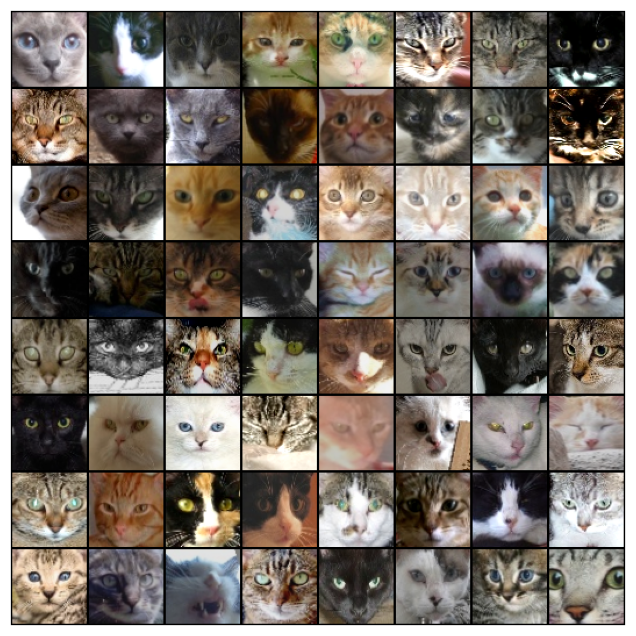

In [70]:
show_batch(train_dl)

In [181]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [182]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [183]:
train_dl = DeviceDataLoader(train_dl, device)

In [184]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    # New layer with 2x2 kernel
    nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    # Additional layer
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 2 x 2

    # Final layer to adjust output size
    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [185]:
discriminator = to_device(discriminator, device)

In [186]:
latent_size = 128

In [187]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    # New layer with 2x2 kernel
    nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    # Additional layer
    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    # Final layer to adjust output size
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


torch.Size([128, 3, 65, 65])


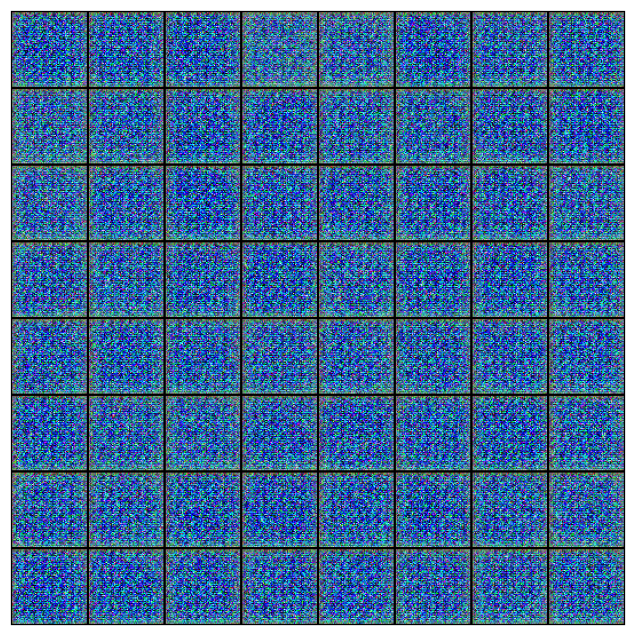

In [188]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [189]:
generator = to_device(generator, device)

In [190]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [191]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [192]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [193]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [194]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 10

In [195]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.3559, loss_d: 0.5951, real_score: 0.8279, fake_score: 0.1698


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 7.4189, loss_d: 0.0704, real_score: 0.9691, fake_score: 0.0342


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.1443, loss_d: 0.5016, real_score: 0.8704, fake_score: 0.1021


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.6442, loss_d: 0.4968, real_score: 0.8515, fake_score: 0.1482


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 3.6082, loss_d: 0.7286, real_score: 0.7656, fake_score: 0.2372


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.9137, loss_d: 0.7343, real_score: 0.7629, fake_score: 0.2310


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.0606, loss_d: 0.7479, real_score: 0.7587, fake_score: 0.2434


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.2710, loss_d: 0.7476, real_score: 0.7573, fake_score: 0.2392


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 3.8183, loss_d: 0.8576, real_score: 0.7290, fake_score: 0.2680


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.0387, loss_d: 0.7510, real_score: 0.7469, fake_score: 0.2459
Saving generated-images-0010.png


In [196]:
save_samples(epochs, fixed_latent, show=False)

Saving generated-images-0010.png


In [201]:
losses_g, losses_d, real_scores, fake_scores = history

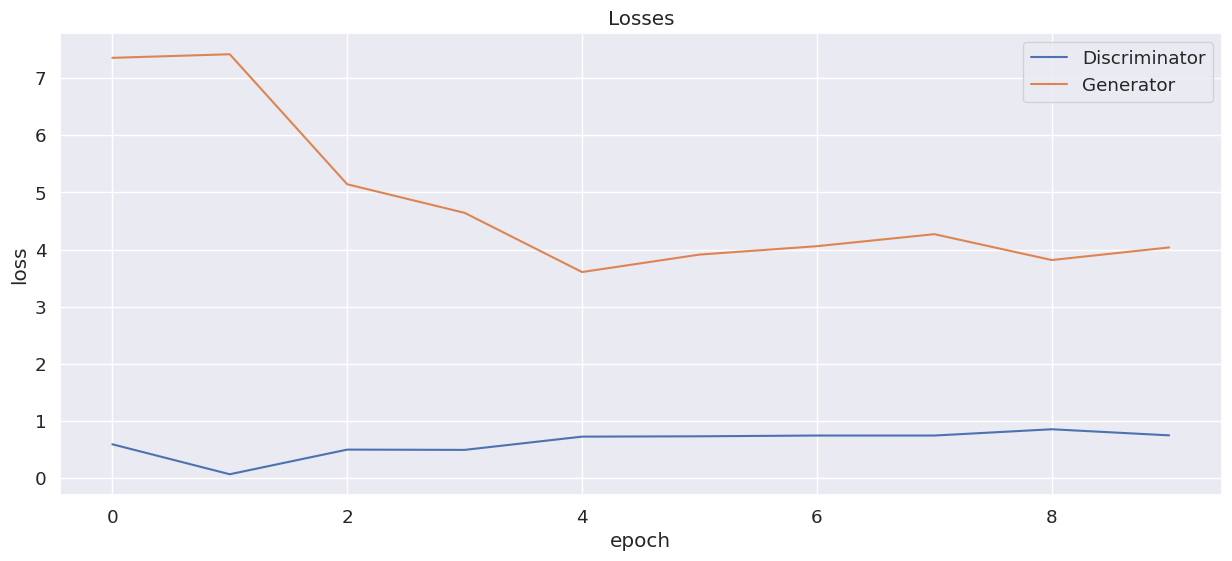

In [202]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

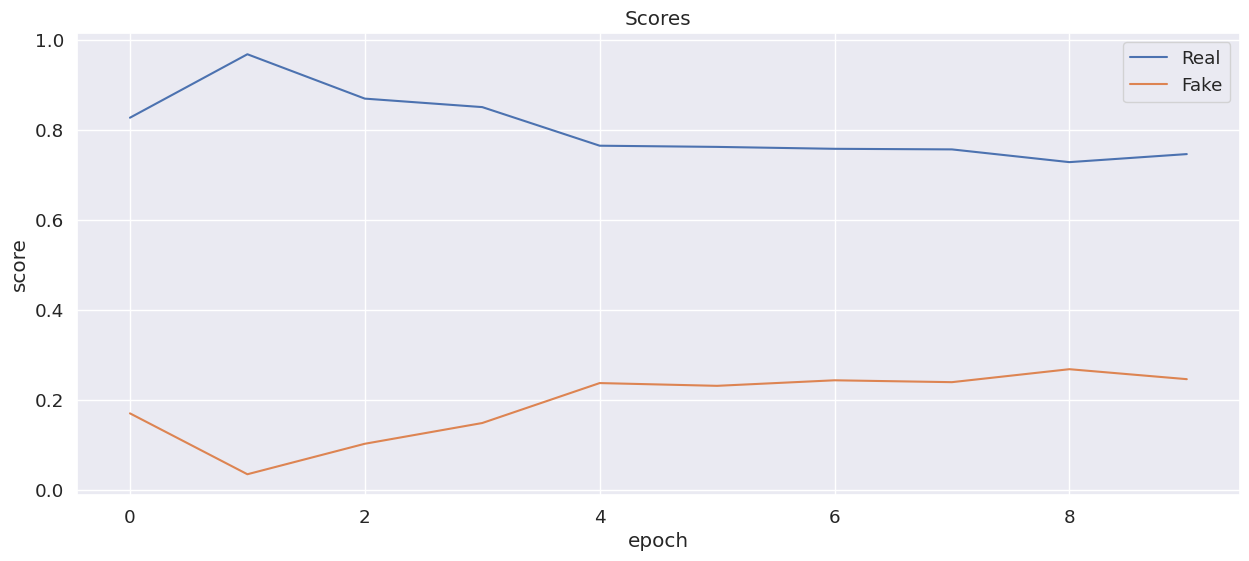

In [203]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [205]:
epochs_per_save = 10
total_epochs = 40

for epoch in range(total_epochs):
    history = fit(model, criterion, epochs_per_save, lr, start_idx=epoch * epochs_per_save + 1)
    losses_g, losses_d, real_scores, fake_scores = history
    plt.figure(figsize=(15, 6))
    plt.plot(losses_d, '-')
    plt.plot(losses_g, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses (Epoch {})'.format(epoch * epochs_per_save + epochs_per_save))
    plt.savefig('losses_epoch_{}.png'.format(epoch * epochs_per_save + epochs_per_save))
    plt.close()

    plt.figure(figsize=(15, 6))
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores (Epoch {})'.format(epoch * epochs_per_save + epochs_per_save))
    plt.savefig('scores_epoch_{}.png'.format(epoch * epochs_per_save + epochs_per_save))
    plt.close()

    save_samples(epoch * epochs_per_save + epochs_per_save, fixed_latent, show=False)


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 4.6580, loss_d: 0.6027, real_score: 0.7991, fake_score: 0.2030


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 4.4454, loss_d: 0.5562, real_score: 0.8087, fake_score: 0.1850


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 4.5482, loss_d: 0.5725, real_score: 0.8138, fake_score: 0.1846


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.8005, loss_d: 0.5451, real_score: 0.8129, fake_score: 0.1786


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.5580, loss_d: 0.5315, real_score: 0.8176, fake_score: 0.1847


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.5968, loss_d: 0.5378, real_score: 0.8172, fake_score: 0.1726


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.8286, loss_d: 0.5301, real_score: 0.8199, fake_score: 0.1817


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.6199, loss_d: 0.5448, real_score: 0.8183, fake_score: 0.1718


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.4474, loss_d: 0.5468, real_score: 0.8146, fake_score: 0.1886


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.4666, loss_d: 0.5330, real_score: 0.8179, fake_score: 0.1750
Saving generated-images-0010.png
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 4.4923, loss_d: 0.5185, real_score: 0.8248, fake_score: 0.1750


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 4.5216, loss_d: 0.4847, real_score: 0.8344, fake_score: 0.1667


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 4.2734, loss_d: 0.5745, real_score: 0.8096, fake_score: 0.1820


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.2585, loss_d: 0.5723, real_score: 0.8162, fake_score: 0.1830


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.0723, loss_d: 0.5369, real_score: 0.8168, fake_score: 0.1807


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.0228, loss_d: 0.5206, real_score: 0.8185, fake_score: 0.1817


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.1511, loss_d: 0.4948, real_score: 0.8281, fake_score: 0.1711


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.9601, loss_d: 0.5228, real_score: 0.8245, fake_score: 0.1669


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 3.7962, loss_d: 0.6236, real_score: 0.7986, fake_score: 0.2006


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 3.5240, loss_d: 0.6070, real_score: 0.7965, fake_score: 0.2000
Saving generated-images-0020.png
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 3.7811, loss_d: 0.5225, real_score: 0.8244, fake_score: 0.1746


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 3.7706, loss_d: 0.5663, real_score: 0.8112, fake_score: 0.1919


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 3.7469, loss_d: 0.5175, real_score: 0.8254, fake_score: 0.1686


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.7483, loss_d: 0.5292, real_score: 0.8217, fake_score: 0.1744


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 3.4983, loss_d: 0.5950, real_score: 0.7994, fake_score: 0.1981


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.2848, loss_d: 0.6510, real_score: 0.7893, fake_score: 0.2092


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 3.2472, loss_d: 0.6294, real_score: 0.7909, fake_score: 0.2072


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.4791, loss_d: 0.5194, real_score: 0.8166, fake_score: 0.1819


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 3.5111, loss_d: 0.5498, real_score: 0.8122, fake_score: 0.1891


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 3.5366, loss_d: 0.5230, real_score: 0.8181, fake_score: 0.1789
Saving generated-images-0030.png
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 3.5698, loss_d: 0.5492, real_score: 0.8188, fake_score: 0.1747


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 3.2685, loss_d: 0.5984, real_score: 0.8022, fake_score: 0.1952


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 3.4741, loss_d: 0.5255, real_score: 0.8174, fake_score: 0.1812


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.4681, loss_d: 0.5800, real_score: 0.8020, fake_score: 0.1972


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 3.3734, loss_d: 0.4904, real_score: 0.8232, fake_score: 0.1794


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.5659, loss_d: 0.5117, real_score: 0.8243, fake_score: 0.1737


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 3.4203, loss_d: 0.5185, real_score: 0.8210, fake_score: 0.1760


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.4836, loss_d: 0.4940, real_score: 0.8216, fake_score: 0.1731


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 3.2656, loss_d: 0.5793, real_score: 0.8075, fake_score: 0.1903


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 3.1632, loss_d: 0.6450, real_score: 0.7935, fake_score: 0.2110
Saving generated-images-0040.png
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Generated Images

Image 10:


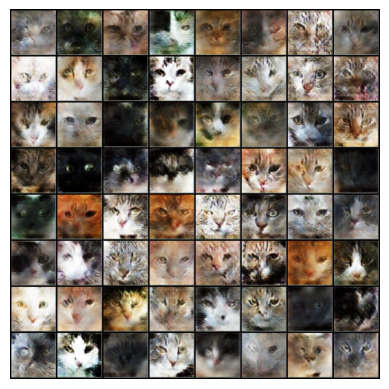

Image 20:


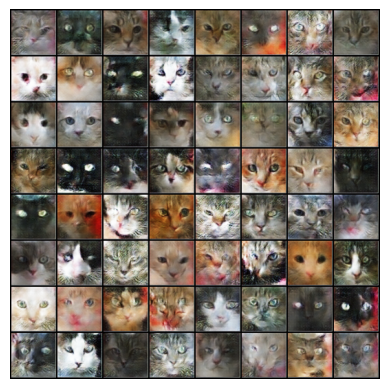

Image 30:


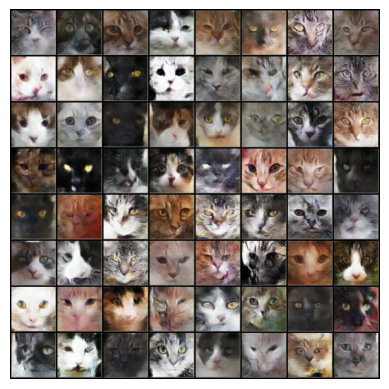

Image 40:


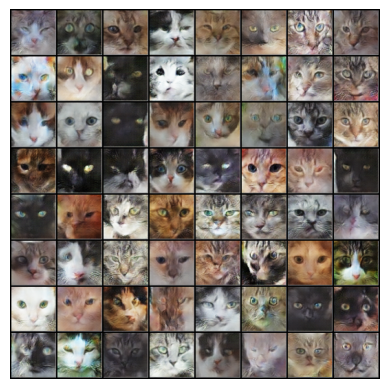

In [206]:
from IPython.display import Image

for i in range(10, 41, 10):
  print(f"Image {i}:")
  img1 = plt.imread(f"/content/generated/generated-images-{i:04d}.png")
  plt.imshow(img1)
  plt.axis('off')
  plt.show()